# Code to demonstrate the Visualization on the training set
Code adapted from Brandon Rose's [clustering notebook](#http://www.brandonrose.org/clustering).

by Vikram Reddy

### [link to visualization section](#Visualization-of-the-training-set)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection  import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

/Users/vikram/anaconda/envs/d3/lib/python3.5/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
train_data_f = "parsed_drug.csv"
test_data_f = "test_binary.csv"
df = pd.read_csv(train_data_f, low_memory=False)

In [3]:
df.head()

,Unnamed: 0,sentenceid,sentence_text,drug_pair,ddi_label,drug1,drug2
0,0,DDI-DrugBank.d519.s3,Laboratory Tests Response to Plenaxis should b...,DDI-DrugBank.d519.s3.p0,0,Plenaxis,testosterone
1,0,DDI-DrugBank.d297.s1,Population pharmacokinetic analyses revealed t...,DDI-DrugBank.d297.s1.p0,0,MTX,NSAIDs
2,1,DDI-DrugBank.d297.s1,Population pharmacokinetic analyses revealed t...,DDI-DrugBank.d297.s1.p1,0,MTX,corticosteroids
3,2,DDI-DrugBank.d297.s1,Population pharmacokinetic analyses revealed t...,DDI-DrugBank.d297.s1.p2,0,MTX,TNF blocking agents
4,3,DDI-DrugBank.d297.s1,Population pharmacokinetic analyses revealed t...,DDI-DrugBank.d297.s1.p3,0,MTX,abatacept


In [4]:
df = df[df['drug1']!=df['drug2']]

In [5]:
df.to_csv('removed_same_drugs.csv', index=False)

#### Let's learn more about our dataset

In [6]:
print("Number of drug pairs with no affect on each other: ", df.loc[df['ddi_label'] == 0].shape)
print("Number of drug pairs that do affect each other: ", df.loc[df['ddi_label'] == 1].shape)

Number of drug paris with no affect on each other:  (19410, 7)
Number of drug pairs that do affect each other:  (3704, 7)


The dataset is very uneven. We might be overfitting

In [7]:
df_new.head()
df.loc[df['ddi_label'] == 1].head()

NameError: name 'df_new' is not defined

### Create training and development sets

In [8]:
def create_train_dev_test():
    random_index = np.random.permutation(df.index)
    df_shuffled = df.ix[random_index, ['drug1', 'drug2', 'sentence_text', 'ddi_label']]
    df_shuffled.reset_index(drop=True, inplace=True)
    rows, columns =  df_shuffled.shape
    train_size = round(rows*.6)
    dev_size   = round(rows*.4)
    df_train = df_shuffled.loc[:train_size]
    df_dev = df_shuffled.loc[train_size:dev_size+train_size].reset_index(drop=True)
    return df_train, df_dev

In [9]:
df_train, df_dev = create_train_dev_test();

### Create test set

In [10]:
df_test = pd.read_csv(test_data_f, low_memory=False)
df_test = df_test[['drug1', 'drug2', 'sentence_text', 'ddi_label']]
print("Number of rows in test set", df_test.shape)
print("Number of ddis that do not affect each other", df_test.loc[df_test.ddi_label == 0].shape)

Number of rows in test set (5265, 4)
Number of ddis that do not affect each other (4381, 4)


### Create feature sets

In [11]:
vec = TfidfVectorizer(ngram_range=(1, 2), max_df=0.8, max_features=1000)
arr_train_feature_sparse = vec.fit_transform(df_train['sentence_text'])
arr_train_feature = arr_train_feature_sparse.toarray()
arr_train_feature.shape

(13869, 1000)

In [12]:
arr_dev_feature_sparse = vec.transform(df_dev["sentence_text"])
arr_dev_feature = arr_dev_feature_sparse.toarray()
arr_dev_feature.shape

(9246, 1000)

In [13]:
arr_test_feature_sparse = vec.transform(df_test["sentence_text"])
arr_test_feature = arr_test_feature_sparse.toarray()
arr_test_feature.shape

(5265, 1000)

### Run Models

In [14]:
nb = MultinomialNB()
nb_model = nb.fit(arr_train_feature, df_train.ddi_label)

In [15]:
nb_predictions = nb_model.predict(arr_dev_feature)

In [16]:
accuracy_score(df_dev.ddi_label, nb_predictions)

0.76130218472853128

In [17]:
nb_predictions[100:200]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0])

In [45]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=8)
print("starting to fit")
knn_model_dev = knn.fit(arr_train_feature, df_train.ddi_label)
print("starting to predict")
knn_pred_dev = knn_model_dev.predict(arr_dev_feature)
#accuracy_score(df_dev.ddi_label, knn_pred_dev)


starting to fit
starting to predict


In [46]:
knn_pred_test = knn_model_dev.predict(arr_test_feature)
# accuracy_score(df_test.ddi_label, knn_pred_test)
from sklearn.metrics import f1_score
print(f1_score(df_dev.ddi_label, knn_pred_dev, average='binary'))
print(f1_score(df_test.ddi_label, knn_pred_test, average='micro'))

0.105590062112
0.834567901235


In [47]:
from sklearn.metrics import f1_score
print(f1_score(df_dev.ddi_label, knn_pred_dev, average=None, pos_label = 1))
print(f1_score(df_test.ddi_label, knn_pred_test, average=None, pos_label = 1))

[ 0.91901923  0.10559006]
[ 0.90916675  0.07438895]


### Create Features

In [18]:
train_data_f = "train_binary_offsets.csv"
test_data_f = "test_binary_offsets.csv"

df_train = pd.read_csv(train_data_f, low_memory=False)
df_test = pd.read_csv(test_data_f, low_memory=False)

trigger_words = []

with open("triggers.txt") as f:
    for line in f:
        trigger_words.append(line.split()[1])
        
trigger_words = set(trigger_words)
negative_words = ['No', 'not', 'neither', 'without', 'lack', 'fail', 
                  'unable', 'abrogate', 'absence', 'prevent', 
                  'unlikely', 'unchanged', 'rarely']

negative_words = set(negative_words)

In [19]:
def num_words_between_drugs(x,row):
    drug1_i = row['drug1offset'].split('-')
    drug2_i = row['drug2offset'].split('-')
    sentence = row['sentence_text']
    pre_phrase = sentence[int(drug1_i[-1])+1:int(drug2_i[0])].split()
    return len(pre_phrase)

def num_drugs_between_drugs(x, row):
    drug1_i = row['drug1offset'].split('-')
    drug2_i = row['drug2offset'].split('-')
    sentence = row['sentence_text']
    pre_phrase = sentence[int(drug1_i[-1])+1:int(drug2_i[0])]
    list_of_drugs = row['drugsinsent'].split(",")[0:-1]
    drugs_in_bet = 0
    for drug in list_of_drugs:
        drug_split = drug.split()
        if(pre_phrase.find(drug_split[0]) != -1):
            drugs_in_bet += 1

    return drugs_in_bet
        
def negation_count(x, row):
    count = 0
    drug1_i = row['drug1offset'].split('-')
    drug2_i = row['drug2offset'].split('-')
    sentence = row['sentence_text']
    first_phrase = sentence[0:int(drug1_i[0])].split()
    mid_phrase = sentence[int(drug1_i[-1])+1:int(drug2_i[0])].split()
    end_phrase = sentence[int(drug2_i[-1])+1:].split()
    before_count = len(set(first_phrase) & negative_words)
    middle_count = len(set(mid_phrase) & negative_words)
    end_count = len(set(end_phrase) & negative_words)
    return before_count, middle_count, end_count

def trigger_count(x, row):
    count = 0
    drug1_i = row['drug1offset'].split('-')
    drug2_i = row['drug2offset'].split('-')
    sentence = row['sentence_text']
    first_phrase = sentence[0:int(drug1_i[0])].split()
    mid_phrase = sentence[int(drug1_i[-1])+1:int(drug2_i[0])].split()
    end_phrase = sentence[int(drug2_i[-1])+1:].split()
    before_count = len(set(first_phrase) & trigger_words)
    middle_count = len(set(mid_phrase) & trigger_words)
    end_count = len(set(end_phrase) & trigger_words)
    return before_count, middle_count, end_count

def verb_count(x, row):
    pattern = r'''(?x)     
    ([A-Z]\.)+                       # abbrevations
    |\w+'\w+                         # contractions
    | \w+(?:(-|(\.\s))(\n)?\w+)*     # words w/ internal hyphens, extend to next line, and with periods like Mrs. Reed
    '''
    count = 0
    drug1_i = row['drug1offset'].split('-')
    drug2_i = row['drug2offset'].split('-')
    sentence = row['sentence_text']
    first_phrase = nltk.pos_tag(nltk.word_tokenize(sentence[0:int(drug1_i[0])]))
    mid_phrase = nltk.pos_tag(nltk.word_tokenize(sentence[int(drug1_i[-1])+1:int(drug2_i[0])]))
    end_phrase = nltk.pos_tag(nltk.word_tokenize(sentence[int(drug2_i[-1])+1:]))

    before_count, middle_count, end_count = 0,0,0
    for tag in first_phrase:
        if tag[1].startswith('V'):
            before_count += 1
    for tag in mid_phrase:
        if tag[1].startswith('V'):
            middle_count += 1
    for tag in end_phrase:
        if tag[1].startswith('V'):
            end_count += 1
    return before_count, middle_count, end_count

def features_around_drug_pairs(result):
    for subtree in result.subtrees():
        if subtree.label() == 'PHRASE': 
            print(subtree)
            break
    return 0

def struct_rept(x, row):
    grammar = r"""
      NP: {<CD|DT|JJ|NN.*|TO>+}          # Chunk sequences of DT, JJ, NN
      PP: {<IN><NP>}               # Chunk prepositions followed by NP
      VP: {<MD|RB|VB.*>+} # Chunk verbs and their arguments
      PHRASE: {<NP|PP>+}
      CLAUSE: {<PHRASE><VP><PHRASE>}           # Chunk NP, VP
    """
    cp = nltk.RegexpParser(grammar)
    sentence = row['sentence_text']
    sentence = nltk.word_tokenize(sentence)
    sentence = nltk.pos_tag(sentence)
    cp = nltk.RegexpParser(grammar)
    result = cp.parse(sentence)
    return features_around_drug_pairs(result)

def tegether(x, row):
    'boolean feature'
    
    
def senti_of_sent(x,row):
    sid = SentimentIntensityAnalyzer()
    sentence = row['sentence_text']
    ss = sid.polarity_scores(sentence)
    for k in sorted(ss):
        print('{0}: {1}, '.format(k, ss[k]), end='')
        print()

In [20]:
from nltk.data import find
import gensim
from gensim.models import Word2Vec
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
model = gensim.models.Word2Vec.load_word2vec_format(word2vec_sample, binary=False)

model.most_similar('drug')

[('drugs', 0.8491185307502747),
 ('Drug', 0.7462925314903259),
 ('narcotics', 0.6429657936096191),
 ('cocaine', 0.6090095639228821),
 ('heroin', 0.6076129674911499),
 ('narcotic', 0.607055127620697),
 ('medication', 0.5420896410942078),
 ('steroid', 0.53950434923172),
 ('pills', 0.5209195017814636),
 ('amphetamines', 0.5175350904464722)]

In [21]:
def build_features(df):
    list_of_features = []
    words_between_drugs = []
    for index, row in df.iterrows():
        words_between_drugs.append(num_words_between_drugs(index,row))
    list_of_features.append(words_between_drugs)

    drugs_between_drugs = []
    for index, row in df.iterrows():
        drugs_between_drugs.append(num_words_between_drugs(index,row))
    list_of_features.append(drugs_between_drugs)
    
    btg, betg, atg = [], [], []
    for index, row in df.iterrows():
        before, between, after = trigger_count(index,row)
        btg.append(before)
        betg.append(between)
        atg.append(after)
    list_of_features.append(btg)
    list_of_features.append(betg)
    list_of_features.append(atg)
    
    n_btg, n_betg, n_atg = [], [], []
    for index, row in df.iterrows():
        before, between, after = trigger_count(index,row)
        n_btg.append(before)
        n_betg.append(between)
        n_atg.append(after)
    list_of_features.append(n_btg)
    list_of_features.append(n_betg)
    list_of_features.append(n_atg)
    
    v_btg, v_betg, v_atg = [], [], []
    for index, row in df.iterrows():
        before, between, after = verb_count(index,row)
        v_btg.append(before)
        v_betg.append(between)
        v_atg.append(after)
    list_of_features.append(v_btg)
    list_of_features.append(v_betg)
    list_of_features.append(v_atg)
        
    return list_of_features

In [22]:
vec = TfidfVectorizer(ngram_range=(1, 2), max_df=0.8, max_features=1000)
arr_train_feature_sparse = vec.fit_transform(df_train['sentence_text'])
arr_train_feature = arr_train_feature_sparse.toarray()

arr_test_feature_sparse = vec.transform(df_test["sentence_text"])
arr_test_feature = arr_test_feature_sparse.toarray()

In [23]:
def convert_to_numpy(list_):
    x = np.asarray(list_)
    y = x.reshape(-1, 1)
    return y

def create_feature_set(mainset,features):
    for list_f in features:
        mainset = np.append(mainset, convert_to_numpy(list_f), axis=1)
    return mainset

In [24]:
train_feature_list = build_features(df_train)
train_feature_set = create_feature_set(arr_train_feature, train_feature_list)

test_feature_list = build_features(df_test)
test_feature_set = create_feature_set(arr_test_feature, test_feature_list)

In [25]:
np.shape(train_feature_list)

[train_feature_list[i][:5] for i in range(0,11)]
#[arr_train_feature[i][:5] for i in range(0,11)]

[[7, 1, 2, 4, 10],
 [7, 1, 2, 4, 10],
 [0, 0, 0, 0, 0],
 [2, 0, 0, 0, 2],
 [2, 2, 2, 1, 0],
 [0, 0, 0, 0, 0],
 [2, 0, 0, 0, 2],
 [2, 2, 2, 1, 0],
 [0, 1, 1, 1, 1],
 [3, 0, 0, 0, 3],
 [0, 3, 3, 2, 0]]

In [26]:
titles = vec.get_feature_names()
titles[:10]

['10',
 '12',
 '1c',
 '1c antiarrhythmics',
 '20',
 '40',
 '50',
 'absorption',
 'absorption of',
 'ace']

### Run model

In [27]:
nb = MultinomialNB()
nb_model = nb.fit(train_feature_set, df_train.ddi_label)

In [28]:
%time nb_predictions = nb_model.predict(test_feature_set)

CPU times: user 24.1 ms, sys: 2.36 ms, total: 26.4 ms
Wall time: 6.68 ms


In [29]:
accuracy_score(df_test.ddi_label, nb_predictions)

0.69401709401709399

In [30]:
from sklearn.metrics import f1_score
print(f1_score(df_test.ddi_label, nb_predictions, average=None, pos_label = 1))

[ 0.79625648  0.38581777]


### Multidimensional scaling to get a Visualization

Code adapted from Brandon Rose's [clustering notebook](#http://www.brandonrose.org/clustering).

In [31]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(train_feature_set)

In [32]:
np.shape(dist)

(24241, 24241)

#### Need to lower the dimension of the train feature set before using MDS:

In [72]:
num = 600
smaller_dist = dist[:num, :num]

In [73]:
binary_interaction_labels = df_train.ddi_label
smaller_interaction_labels = binary_interaction_labels[:num]

In [74]:
np.shape(smaller_interaction_labels)

(600,)

In [75]:
smaller_titles = titles[:num]

#### Let's take a look at the relevant features in this smaller training set

In [40]:
titles = vec.get_feature_names()
titles[:10]

['10',
 '12',
 '1c',
 '1c antiarrhythmics',
 '20',
 '40',
 '50',
 'absorption',
 'absorption of',
 'ace']

#### Save this model to upload later from this point

In [41]:
from sklearn.externals import joblib

joblib.dump(nb_model,  'rf_DDI.pkl')
nb_model = joblib.load('rf_DDI.pkl')
#labels = nb_model.labels_.tolist()

In [42]:
np.shape(dist)

(24241, 24241)

In [43]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

# shape (n_components, n_samples)
%time pos = mds.fit_transform(smaller_dist)  

xs, ys = pos[:, 0], pos[:, 1]

CPU times: user 14.2 s, sys: 161 ms, total: 14.4 s
Wall time: 3.61 s


### Visualization of the training set

#### Now repeat the same Visualization steps, but using 600 out of the 24000 points instead of only 300.

In [ ]:
#set up colors per interaction using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02'}

#set up cluster names using a dict
cluster_names = {0: 'No Interaction exists', 
                 1: 'An Interaction exists'
                }

In [70]:
%matplotlib inline

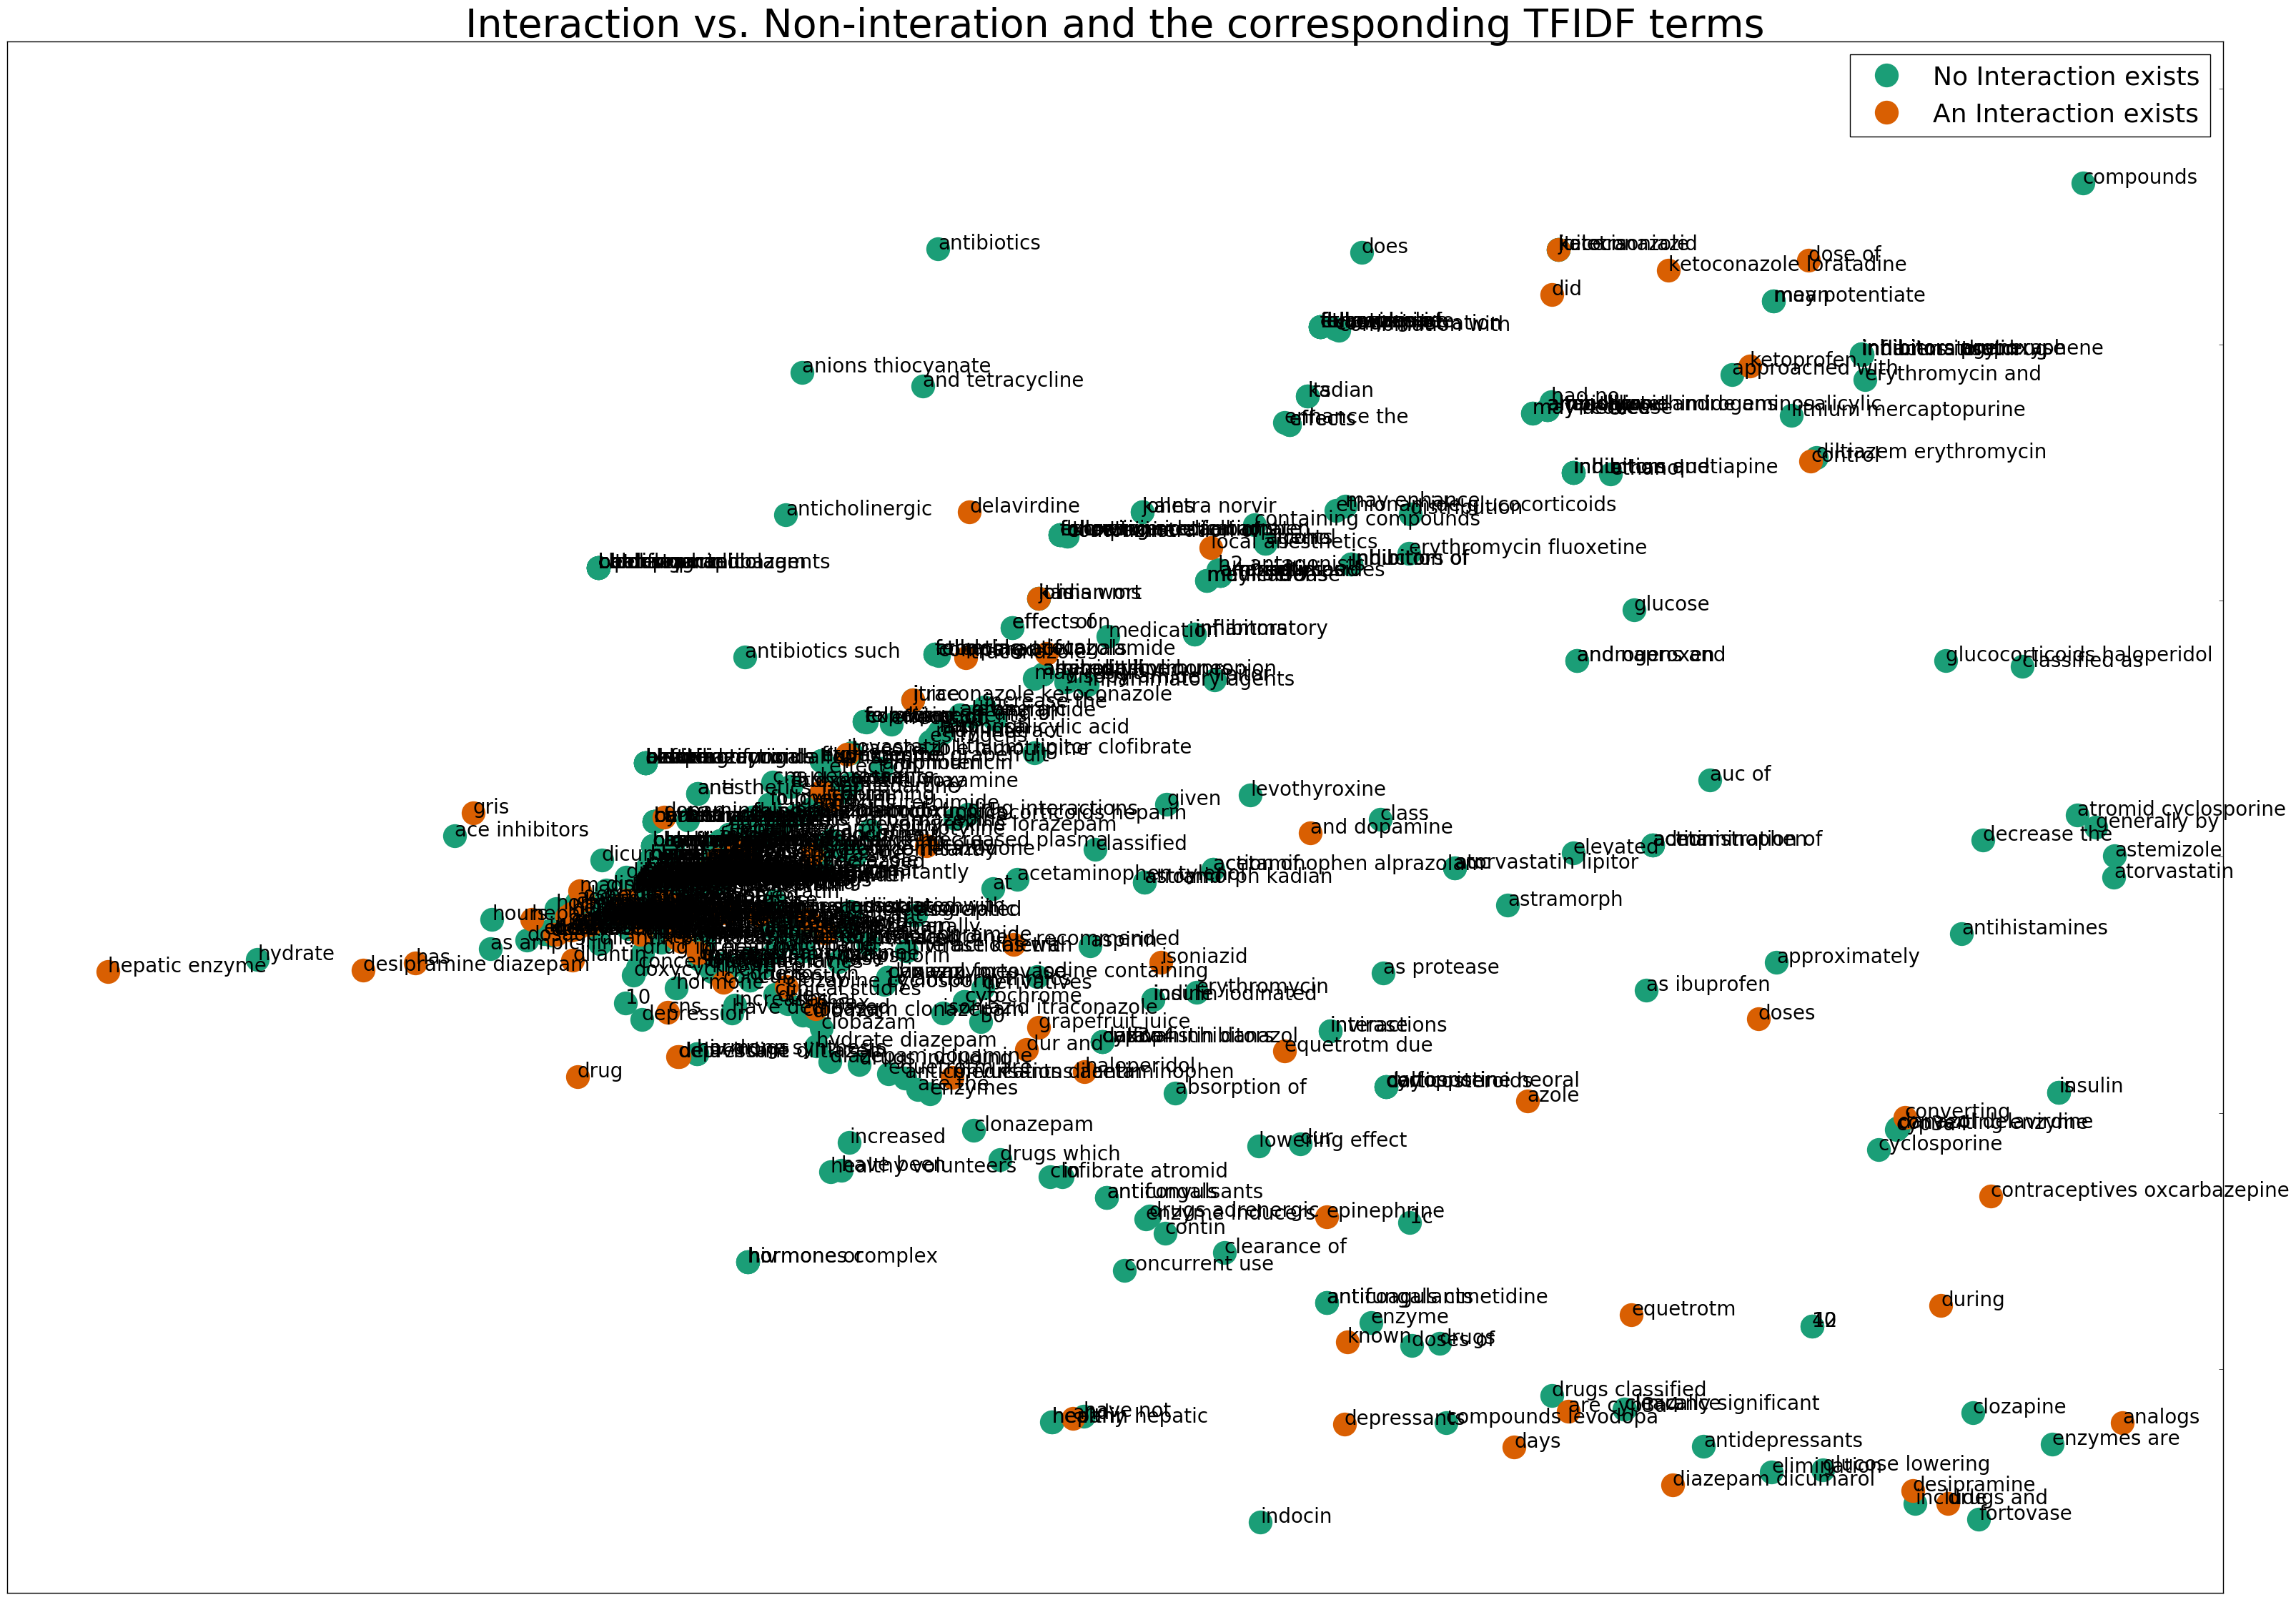

In [77]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df_viz = pd.DataFrame(dict(x=xs, y=ys, label=smaller_interaction_labels,
                      title=smaller_titles))

#group by cluster
groups = df_viz.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(40, 28)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=24, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1,prop={'size':26})  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df_viz)):
    ax.text(df_viz.ix[i]['x'], df_viz.ix[i]['y'], df_viz.ix[i]['title'],
            size=20)  

ax.set_title('Interaction vs. Non-interation and the corresponding ' +
             'TFIDF terms', size=40)
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [52]:
import mpld3
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [58]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=smaller_interaction_labels, 
                       title=smaller_titles)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], mec='none', color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1, loc=2) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)

In [28]:
test_feature_set.shape

(5265, 1011)

In [29]:
len(trigger_words)

297

In [17]:
for index, row in df_train.iterrows():
    print(type(row))
    dumb = struct_rept(index,row)
#     dumb[0].draw()
    break
#     for tree in inaugural_chunks:
#     for subtree in tree.subtrees():
#         if subtree.label() == 'NC': 
#             print(subtree)
            
# print("Done")
#     break

<class 'pandas.core.series.Series'>
(PHRASE
  (NP Laboratory/NNP Tests/NNPS Response/NNP to/TO Plenaxis/NNP))


In [203]:
df_train['sentence_text'].to_csv('~/Desktop/drug_sentences.csv', index=False)

In [32]:
df_train['drug1offset'][116]


'98-107;124-144'

In [18]:
#df_train